In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


import torch 
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt

### Last lesson:
**The sequential Neural Network**

A mathematical way of describing the structure we have been using is

$$f(x) = {\huge\kappa}^{n}_{i=1} R_i (A_i x + b_i)$$

where 
$${\huge\kappa}^{n}_{i=1} f_i(x) = f_n \circ f_{n-1} \circ ... \circ  f_1 (x)$$
and $A_i$ are matrices and the $b_i$ are bias vectors. $R_i$ are the activation functions.

- **Note**: In clever architectures, like convolutional neural networks, the $A_i$'s become sparse matrices (most elements are fixed to equal zero)

## MNIST Dataset

In [2]:
data = MNIST('mnist')

x, y = data.load_training()
x = torch.tensor(x).reshape(60000, 28, 28)
y = torch.tensor(y)

Now we've load 60000 images of $28x28$

In [5]:
def plot_image(xi, yi):
    plt.imshow(xi.numpy())
    plt.title('Number {}'.format(yi))
    plt.colorbar()
    plt.show()

example

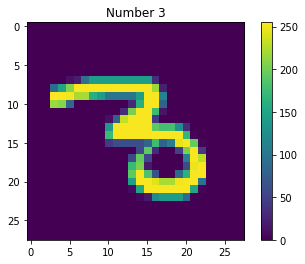

In [6]:
plot_image(x[30], y[30])

## The hot one encoder
Brief theory section, when dealing with classification tasks the fact that the image above shows a $4$ does not mean that image has a larger magnitude than if it was a $2$ for example, we only care about the **class** they belong to, so instead of treating that label like a number we can **encode** it so it represents a class

In [17]:
y_original = torch.tensor([2, 4, 3, 0, 1, 6])
y_original

tensor([2, 4, 3, 0, 1, 6])

In [18]:
y_new = F.one_hot(y_original)
y_new

tensor([[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]])

now that it is encode we see that the number $2$ belongs to the second class, the number $4$ to the fourth, etc. In a nutshell we've created a vector encoding where we have as many places as there are classes and belonging to a class means having $1$ in that position of the vector. 

This unit vectors are very efficient to work with when using the **cross entropy loss function**, we can interpret each position as the probability of the image belonging to that class (probability mass function of known data)

### Using the hot one encoder on the Dataset MNIST
In this dataset we have $60000$ different images of numbers from $0$ to $9$ so

In [7]:
y.shape

torch.Size([60000])

In [8]:
y_new = F.one_hot(y, num_classes = 10)
y_new.shape

torch.Size([60000, 10])

In [9]:
y_new

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

### Preparing the data for Deep Learning:

As we've seen in previous lectures we are looking for a function such that given a sample $x_i$ (vector) we get a prediction $y_i$

$$y_i = f(x_i)$$

In this case each sample $x_i$ is a $28x28$ image so we need to transform it into a usable vector form:

In [10]:
x.shape

torch.Size([60000, 28, 28])

In [11]:
# transforming the data with the .view() built-in method of tensors
"""-1 is a PyTorch alias for "infer this dimension given the others
    have all been specified" (i.e. the quotient of the original 
    product by the new product). It is a convention taken from 
    numpy.reshape().
    Hence t.view(1,17) in the example would be equivalent to 
    t.view(1,-1) or t.view(-1,17)."""
x.view(-1, 28*28).shape

torch.Size([60000, 784])

# Pytorch Dataset and Dataloader Objects

In [12]:
Dataset?

In [14]:
DataLoader?

Theese are classes that help us load and process data for deep learning applications. 
Since deep learning requires a lot of data so we need to load it and process it efficiently.
The Dataset class have access to all our data, the DataLoader class is fed with the Dataset object.

**How do theese classes access our data?**

When ask for samples the dataloader class calls the dataset in a parallelized fashion getting individual samples that will process and unite in the form of batches which can be acessed to when using 'for batch in trainloader'

In [2]:
class CTDataset(Dataset):
    def __init__(self, dtype):
        data = MNIST('mnist')
        if dtype == 'train':
            x, y = data.load_training()
            self.x = torch.tensor(x).reshape(60000, 28, 28)
            self.y = torch.tensor(y)
        else:
            x, y = data.load_testing()
            self.x = torch.tensor(x).reshape(10000, 28, 28)
            self.y = torch.tensor(y)
        self.x = self.x / 255. # normalization of RGB format
        self.y = F.one_hot(self.y, num_classes = 10).to(float)
    def __len__(self):
        return self.x.shape[0] # number of images
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix] # complete image and label of the ix-th image

In [3]:
train_ds = CTDataset('train')
test_ds = CTDataset('test')

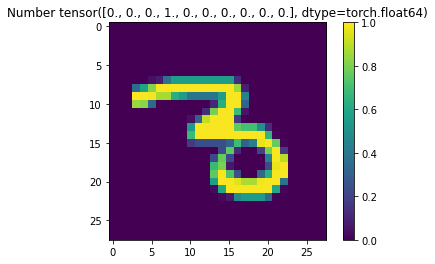

In [6]:
plot_image(*train_ds[30]) # example of the getitem bult-in method

### We can also use slicing:

In [8]:
train_ds[5:10][0].shape

torch.Size([5, 28, 28])

In [9]:
train_ds[5:10][1]

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)

## Using dataloaders:
We can now put the Dataset object inside a DataLoader class. This is useful because we can specify a **batch_size**. Each iteration through the dataloader will yield a tensor where the **first dimension** is equal to the batch_size.

In [11]:
train_dl = DataLoader(train_ds, batch_size = 5)

In [13]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break # only want one example

torch.Size([5, 28, 28])
torch.Size([5, 10])


Since batch_size here is $5$, and there are $60000$ images, the length of the DataLoader object should be $12000$ (number of batches)

In [14]:
len(train_dl)

12000

### Cross entropy loss: 

In [15]:
L = nn.CrossEntropyLoss()

### The Network:

In [23]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28*28, 100)
        self.Matrix2 = nn.Linear(100, 50)
        self.Matrix3 = nn.Linear(50, 10)
        self.R = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))        
        x = self.Matrix3(x)
        return x.squeeze()

In [24]:
f = MyNeuralNet()

Look at predictions before the optimization:

In [25]:
xs, ys = train_ds[0:4]
f(xs)

tensor([[ 0.0123,  0.1811, -0.1312,  0.0050,  0.1147,  0.0407,  0.2408,  0.1182,
          0.0510,  0.0550],
        [-0.0016,  0.2129, -0.1230,  0.0195,  0.1228,  0.0148,  0.1911,  0.0976,
          0.0567, -0.0095],
        [-0.0148,  0.1712, -0.1578,  0.0104,  0.1553, -0.0202,  0.1532,  0.0631,
          0.0422,  0.0061],
        [-0.0130,  0.1884, -0.1700,  0.0011,  0.1432, -0.0137,  0.1775,  0.1041,
          0.0405, -0.0094]], grad_fn=<SqueezeBackward0>)

In [26]:
ys

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

**Loss of these predictions**

In [27]:
L(f(xs), ys)

tensor(2.2649, dtype=torch.float64, grad_fn=<DivBackward1>)

## Training

In [29]:
def train_model(dl, f, n_epochs = 20):
    opt = SGD(f.parameters(), lr = 0.01)
    L = nn.CrossEntropyLoss()
    
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print('Epoch {}'.format(epoch))
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [30]:
# this will take aroung 3-4 minutes
epoch_data, loss_data = train_model(train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
